# HW-3

In [1]:
import wikipedia
import warnings
warnings.filterwarnings("ignore")
import re

In [2]:
? wikipedia

In [183]:
#wikipedia.languages()

In [2]:
languages = wikipedia.languages().keys()
languages

dict_keys(['aa', 'ab', 'ace', 'ady', 'ady-cyrl', 'aeb', 'aeb-arab', 'aeb-latn', 'af', 'ak', 'aln', 'als', 'am', 'an', 'ang', 'anp', 'ar', 'arc', 'arn', 'arq', 'ary', 'arz', 'as', 'ase', 'ast', 'atj', 'av', 'avk', 'awa', 'ay', 'az', 'azb', 'ba', 'ban', 'bar', 'bat-smg', 'bbc', 'bbc-latn', 'bcc', 'bcl', 'be', 'be-tarask', 'be-x-old', 'bg', 'bgn', 'bh', 'bho', 'bi', 'bjn', 'bm', 'bn', 'bo', 'bpy', 'bqi', 'br', 'brh', 'bs', 'bto', 'bug', 'bxr', 'ca', 'cbk-zam', 'cdo', 'ce', 'ceb', 'ch', 'cho', 'chr', 'chy', 'ckb', 'co', 'cps', 'cr', 'crh', 'crh-cyrl', 'crh-latn', 'cs', 'csb', 'cu', 'cv', 'cy', 'da', 'de', 'de-at', 'de-ch', 'de-formal', 'din', 'diq', 'dsb', 'dtp', 'dty', 'dv', 'dz', 'ee', 'egl', 'el', 'eml', 'en', 'en-ca', 'en-gb', 'eo', 'es', 'es-formal', 'et', 'eu', 'ext', 'fa', 'ff', 'fi', 'fit', 'fiu-vro', 'fj', 'fo', 'fr', 'frc', 'frp', 'frr', 'fur', 'fy', 'ga', 'gag', 'gan', 'gan-hans', 'gan-hant', 'gcr', 'gd', 'gl', 'glk', 'gn', 'gom', 'gom-deva', 'gom-latn', 'gor', 'got', 'grc', 'gs

** Выберем несколько языков:**

- славянские языки
- европейские языки (романские и другие с латинским алфавитом)
- с иероглифической и другими письменностями

In [3]:
languages = ['el','gom','hy','ja','ko','zh','ps',
             'ru','be','kk','bg','mk','ba','sr','tt','tg','sl',
            'af','en','fr','la','no','pl','pt','es','ca','de']

Скачиваем статьи для обучения. Лучше расширить exception, сделав общий, так как есть другие ошибки.

In [6]:
def get_texts_for_lang(lang, n=10): # функция для скачивания статей из википедии
    wikipedia.set_lang(lang)
    wiki_content = []
    pages = wikipedia.random(n)
    for page_name in pages:
        try:
            page = wikipedia.page(page_name)
        except:
            #print('Skipping page {}'.format(page_name))
            continue

        wiki_content.append('{}\n{}'.format(page.title, page.content.replace('==', '')))

    return wiki_content

Загружаем статьи, выводим количество для контроля размера корпуса

In [7]:
wiki_texts = {}
for lang in languages:
    wiki_texts[lang] = get_texts_for_lang(lang, 100)
    print(lang, len(wiki_texts[lang]))

el 95
gom 100
hy 93
ja 94
ko 92
zh 97
ps 99
ru 83
be 96
kk 99
bg 98
mk 100
ba 99
sr 89
tt 97
tg 99
sl 97
af 97
en 91
fr 99
la 99
no 100
pl 91
pt 97
es 94
ca 97
de 91


Тестовая выборка

In [33]:
TEST = {}
for lang in languages:
    TEST[lang] = get_texts_for_lang(lang, 50)
    print(lang, len(TEST[lang]))

el 48
gom 50
hy 48
ja 48
ko 46
zh 50
ps 50
ru 48
be 49
kk 50
bg 47
mk 50
ba 50
sr 47
tt 45
tg 49
sl 48
af 49
en 43
fr 46
la 50
no 50
pl 48
pt 48
es 46
ca 49
de 48


In [9]:
import pickle as pkl

In [10]:
with open('wiki_27_100.pkl', 'wb') as f:
    pkl.dump(wiki_texts, f)

In [51]:
with open('wiki_27_100.pkl', 'rb') as f:
    wiki_texts = pkl.load(f)

In [34]:
with open('wiki_27_100_test.pkl', 'wb') as f:
    pkl.dump(TEST, f)

In [ ]:
with open('wiki_27_100_test.pkl', 'rb') as f:
    TEST = pkl.load(f)

In [15]:
from collections import defaultdict
from string import punctuation, digits
import codecs
import collections
import sys
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline  

## Первый способ: частотный словарь

Токенизация. Выбираем численно-буквенные символы и пробелы, затем убираем цифры. Делим по пробелам

In [66]:
def tokenize(text):
    text = re.sub(r'[^\w\s]','',text).replace('\n', '')
    text = re.sub(r'\d','',text)
    text = re.sub(r'[\s]{2,}',' ',text)
    return text.split(' ')

** Частоты словоформ. **

- считаем
- печатаем размер обучающего корпуса по языкам
- нормируем по частоте (0-1, очень маленькие числа, 1 - сумма в корпусе)
- ограничиваем 500 самых частотных (экономия памяти, экономия времени, не очень потеря в качестве)


Нет смысла исключать повторяющиеся элементы, так как учет частоты (ранга) решает эту проблему, к тому же, при принципиально разных языках (китайским и русским, например), дополнительные частоты в сумме добавляют надежности.

In [162]:
total_freqs = collections.defaultdict(lambda: collections.defaultdict(lambda: 0))
for lang in wiki_texts.keys():
    for article in wiki_texts[lang]:
        for word in tokenize(article.replace('\n', '').lower()):
            total_freqs[lang][word] += 1

for lang in wiki_texts.keys():
    print('{}\t{}\t{}'.format(lang, sum(total_freqs[lang].values()), len(total_freqs[lang])))

            
for lang in wiki_texts.keys():
    summ = sum(total_freqs[lang].values())
    for word in total_freqs[lang]:
        total_freqs[lang][word] = total_freqs[lang][word]/summ

for lang in wiki_texts.keys():
    total_freqs[lang] = {i[0]:i[1] for i in collections.Counter(total_freqs[lang]).most_common(500)}

el	29025	9912
gom	49006	14217
hy	21399	8705
ja	3683	3010
ko	43261	19102
zh	4029	3162
ps	20426	5720
ru	40817	15943
be	13609	6419
kk	11031	4775
bg	17825	6878
mk	37599	9347
ba	20179	6961
sr	14262	5399
tt	10252	3680
tg	5560	2076
sl	26005	9859
af	36859	7989
en	34895	8049
fr	65172	13326
la	18769	6226
no	33584	9271
pl	17712	7945
pt	50298	10893
es	38022	9439
ca	27989	7440
de	42865	13087


Учтенные словоформы из корпуса. 500 словоформ покрывают 30-60%

In [170]:
for lang in wiki_texts.keys():
    print(lang+'\t',sum(total_freqs[lang].values()))

el	 0.5223083548664905
gom	 0.4584744725135709
hy	 0.4412823029113512
ja	 0.31849036111865014
ko	 0.3824229675689466
zh	 0.3392901464383173
ps	 0.6204347400372033
ru	 0.40519881421956705
be	 0.4577852891468901
kk	 0.494062188378207
bg	 0.5248807854137418
mk	 0.5745099603712865
ba	 0.5440804797066289
sr	 0.5618426588136222
tt	 0.6094420600858413
tg	 0.6861510791366856
sl	 0.48621418957892387
af	 0.6563661520931117
en	 0.5936667144289988
fr	 0.5969588166697369
la	 0.5758964249560434
no	 0.5855764649833252
pl	 0.4504290876242133
pt	 0.5962463716251148
es	 0.5978906948608771
ca	 0.6095608989245718
de	 0.5369182316575264


In [171]:
for word in sorted(total_freqs['kk'], key=lambda w: total_freqs['kk'][w], reverse=True)[:5]:
    print('{}\t{}'.format(total_freqs['kk'][word], word))

0.014323270782340676	және
0.009518629317378298	су
0.008430785966820778	бойынша
0.0066177137158915786	дереккөздер
0.006436406490798658	мен


In [172]:
def predict_language_word(text, total_freqs):
    text_words = tokenize(text)
    variants = {}
    
    for lang in total_freqs.keys():
        summ = 0
        for word in text_words:
            if word in total_freqs[lang]:
                summ += total_freqs[lang][word]
        variants[lang] = summ
    
    return max(variants, key=lambda x: variants[x])
#     return lang2sim

In [173]:
def print_result(corpus, fnctn, source):
    true_labels = []
    predicted_labels = []

    for lang in corpus.keys():
        for text in corpus[lang]:
            true_labels.append(lang)
            predicted_labels.append(fnctn(text, source))
    print(classification_report(true_labels, predicted_labels))

    labels = list(set(true_labels))

    fig, ax = plt.subplots(figsize=(10,5))
    sns.heatmap(data=confusion_matrix(true_labels, predicted_labels, labels = labels), 
                annot=True, 
                fmt="d", xticklabels=labels, yticklabels=labels, ax=ax)
    plt.title("Confusion matrix")
    plt.show()

             precision    recall  f1-score   support

         af       0.75      1.00      0.86        97
         ba       0.99      0.95      0.97        99
         be       1.00      0.80      0.89        96
         bg       0.65      0.99      0.78        98
         ca       0.95      0.54      0.68        97
         de       0.96      0.97      0.96        91
         el       0.85      0.98      0.91        95
         en       0.55      1.00      0.71        91
         es       0.48      1.00      0.65        94
         fr       0.89      0.79      0.83        99
        gom       1.00      0.63      0.77       100
         hy       1.00      0.96      0.98        93
         ja       0.99      0.72      0.83        94
         kk       1.00      0.93      0.96        99
         ko       1.00      0.93      0.97        92
         la       1.00      0.59      0.74        99
         mk       0.97      0.97      0.97       100
         no       0.97      0.95      0.96   

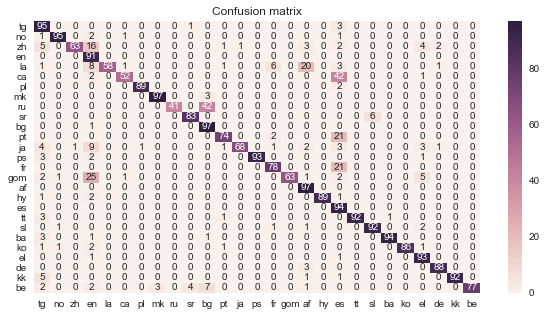

In [102]:
print_result(wiki_texts, predict_language_word, total_freqs)

             precision    recall  f1-score   support

         af       0.80      1.00      0.89        49
         ba       0.96      0.96      0.96        50
         be       1.00      0.80      0.89        49
         bg       0.63      0.98      0.77        47
         ca       1.00      0.53      0.69        49
         de       0.98      0.94      0.96        48
         el       0.83      1.00      0.91        48
         en       0.45      1.00      0.62        43
         es       0.49      1.00      0.66        46
         fr       0.88      0.83      0.85        46
        gom       1.00      0.62      0.77        50
         hy       1.00      0.96      0.98        48
         ja       0.97      0.65      0.78        48
         kk       1.00      0.86      0.92        50
         ko       1.00      0.93      0.97        46
         la       1.00      0.58      0.73        50
         mk       0.96      1.00      0.98        50
         no       0.98      1.00      0.99   

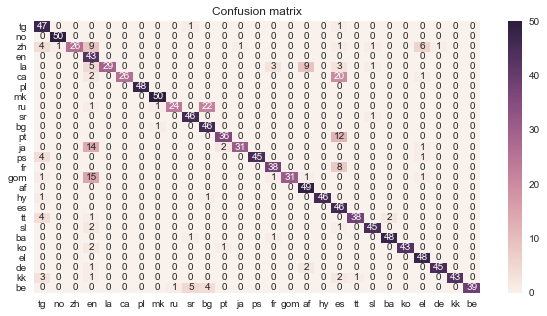

In [103]:
print_result(TEST, predict_language_word, total_freqs)

## Второй способ: частотные символьные n-grams

### Триграммы

In [144]:
from itertools import islice, tee

def make_ngrams(text):
    N = 3 # задаем длину n-граммы
    text = re.sub(r'[^\w\s]','',text).replace('\n', '')
    text = re.sub(r'\d','',text)
    text = re.sub(r'[\s]{2,}',' ',text)
    ngrams = zip(*(islice(seq, index, None) for index, seq in enumerate(tee(text, N))))
    ngrams = [''.join(x) for x in ngrams]
    return ngrams

In [145]:
total_ngrams = collections.defaultdict(lambda: collections.defaultdict(lambda: 0))

for lang in wiki_texts.keys():
    for article in wiki_texts[lang]:
        for word in make_ngrams(article.replace('\n', '').lower()):
            total_ngrams[lang][word] += 1

for lang in wiki_texts.keys():
    print('{}\t{}\t{}'.format(lang, sum(total_ngrams[lang].values()), len(total_ngrams[lang])))

for lang in wiki_texts.keys():
    summ = sum(total_ngrams[lang].values())
    for word in total_ngrams[lang]:
        total_ngrams[lang][word] = total_ngrams[lang][word]/summ
        
for lang in wiki_texts.keys():
    total_ngrams[lang] = {i[0]:i[1] for i in collections.Counter(total_ngrams[lang]).most_common(500)}

el	197978	13194
gom	250818	16721
hy	170924	12601
ja	160070	84829
ko	176320	55455
zh	179704	131928
ps	98471	9989
ru	295659	12900
be	100096	8653
kk	90705	6150
bg	116765	8841
mk	243708	8608
ba	154370	10426
sr	94013	6789
tt	75935	6723
tg	40933	5226
sl	172665	7020
af	227879	6428
en	215040	6291
fr	409807	8178
la	133880	5305
no	216285	7152
pl	130860	7943
pt	309141	7433
es	239181	7097
ca	167962	6761
de	315642	8961


Триграммы покрывают 50-60% корпуса. Это в среднем лучше, чем при словоформах. Однако здесь есть принципиальные "провалы": японский, корейский, китайский. Здесь значения очень низкие. Это связано с тем, что с этих языках отдельные графемы(?) более разнообразные и несут больше смысла. Их комбинаций во много раз больше (что видно из предыдущего вывода), поэтому значения доли 500 ниже.

In [174]:
for lang in wiki_texts.keys():
    print(lang+'\t',sum(total_ngrams[lang].values()))

el	 0.49748456899251453
gom	 0.4160905517147887
hy	 0.5199386861997155
ja	 0.13693384144436788
ko	 0.2505614791288569
zh	 0.07581912478297625
ps	 0.5393669202100113
ru	 0.476934576657569
be	 0.4922074808184139
kk	 0.5929331348878237
bg	 0.543322057123282
mk	 0.6214773417368318
ba	 0.5252056746777226
sr	 0.5923755225341162
tt	 0.5772963718970173
tg	 0.5766496469840965
sl	 0.5745171285437132
af	 0.6637294353582391
en	 0.6062034970238104
fr	 0.6487468491265401
la	 0.6181953988646547
no	 0.6163719166840058
pl	 0.4984028732997093
pt	 0.653397640558839
es	 0.650427918605575
ca	 0.6340958073850043
de	 0.6157197077701958


In [176]:
for word in sorted(total_ngrams['kk'], key=lambda w: total_ngrams['kk'][w], reverse=True)[:5]:
    print('{}\t{}'.format(total_ngrams['kk'][word], word))

0.005468276280249159	 қа
0.005280855520643846	ан 
0.004950113003693291	ың 
0.004872939749738162	ен 
0.004872939749738162	ды 


In [236]:
def predict_language_ngrams(text, a):
    text_words = make_ngrams(text)
    variants = {}
    
    for lang in a.keys():
        summ = 0
        for word in text_words:
            if word in a[lang]:
                summ += a[lang][word]
        variants[lang] = summ
    
    return max(variants, key=lambda x: variants[x])
#     return lang2sim

             precision    recall  f1-score   support

         af       0.88      1.00      0.94        97
         ba       1.00      0.97      0.98        99
         be       1.00      0.96      0.98        96
         bg       0.85      0.83      0.84        98
         ca       0.96      0.97      0.96        97
         de       0.78      1.00      0.88        91
         el       0.92      0.99      0.95        95
         en       0.55      1.00      0.71        91
         es       0.79      0.99      0.88        94
         fr       0.89      0.99      0.94        99
        gom       1.00      0.54      0.70       100
         hy       1.00      0.99      0.99        93
         ja       0.86      0.73      0.79        94
         kk       1.00      1.00      1.00        99
         ko       1.00      0.91      0.95        92
         la       0.86      0.97      0.91        99
         mk       0.72      1.00      0.84       100
         no       0.92      0.96      0.94   

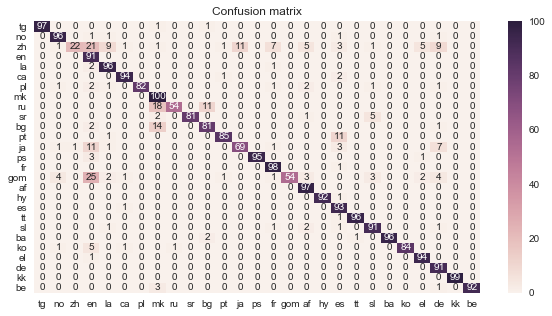

In [237]:
print_result(wiki_texts, predict_language_ngrams, total_ngrams)

             precision    recall  f1-score   support

         af       0.94      1.00      0.97        49
         ba       1.00      0.98      0.99        50
         be       1.00      0.98      0.99        49
         bg       0.77      0.77      0.77        47
         ca       0.94      0.94      0.94        49
         de       0.83      1.00      0.91        48
         el       0.96      1.00      0.98        48
         en       0.49      1.00      0.66        43
         es       0.82      1.00      0.90        46
         fr       0.87      1.00      0.93        46
        gom       1.00      0.48      0.65        50
         hy       1.00      1.00      1.00        48
         ja       0.81      0.54      0.65        48
         kk       1.00      1.00      1.00        50
         ko       1.00      0.91      0.95        46
         la       0.84      0.94      0.89        50
         mk       0.71      1.00      0.83        50
         no       0.98      1.00      0.99   

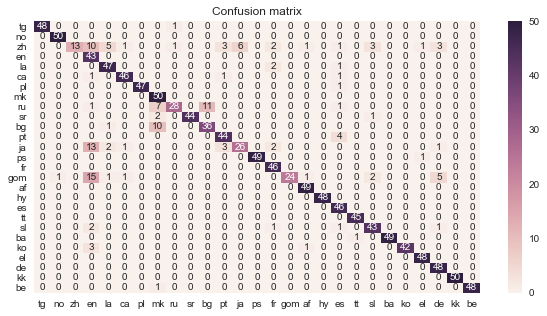

In [150]:
print_result(TEST, predict_language_ngrams, total_ngrams)

### Биграммы

In [151]:
def make_bigrams(text):
    N = 2 # задаем длину n-граммы
    text = re.sub(r'[^\w\s]','',text).replace('\n', '')
    text = re.sub(r'\d','',text)
    text = re.sub(r'[\s]{2,}',' ',text)
    ngrams = zip(*(islice(seq, index, None) for index, seq in enumerate(tee(text, N))))
    ngrams = [''.join(x) for x in ngrams]
    return ngrams

total_bigrams = collections.defaultdict(lambda: collections.defaultdict(lambda: 0))

for lang in wiki_texts.keys():
    for article in wiki_texts[lang]:
        for word in make_bigrams(article.replace('\n', '').lower()):
            total_bigrams[lang][word] += 1

for lang in wiki_texts.keys():
    print('{}\t{}\t{}'.format(lang, sum(total_bigrams[lang].values()), len(total_bigrams[lang])))

for lang in wiki_texts.keys():
    summ = sum(total_bigrams[lang].values())
    for word in total_bigrams[lang]:
        total_bigrams[lang][word] = total_bigrams[lang][word]/summ

for lang in wiki_texts.keys():
    total_bigrams[lang] = {i[0]:i[1] for i in collections.Counter(total_bigrams[lang]).most_common(500)}

el	198073	1868
gom	250918	2484
hy	171017	2163
ja	160164	36018
ko	176412	18794
zh	179801	76661
ps	98570	1813
ru	295742	1858
be	100192	1492
kk	90804	1228
bg	116863	1444
mk	243808	1360
ba	154469	1773
sr	94102	1096
tt	76032	1322
tg	41032	1191
sl	172762	1143
af	227976	983
en	215131	946
fr	409906	1256
la	133979	822
no	216385	1065
pl	130951	1163
pt	309238	1038
es	239275	1086
ca	168059	1061
de	315733	1241


500 биграмм покрывают большее (или почти всё в алфавитных языках) множество комбинаций. С иероглифами остается та же проблема, что и с триграммами.

In [180]:
for lang in wiki_texts.keys():
    print(lang+'\t',sum(total_bigrams[lang].values()))

el	 0.912532248211518
gom	 0.8775615938274652
hy	 0.8985714870451482
ja	 0.30879598411628084
ko	 0.5525134344602407
zh	 0.179259292217507
ps	 0.9165466166176321
ru	 0.9462741173049485
be	 0.9483092462472045
kk	 0.970871327254305
bg	 0.9517811454438103
mk	 0.9753781664260399
ba	 0.9380328739099758
sr	 0.972678582814394
tt	 0.9560974326599366
tg	 0.9510382140768201
sl	 0.9918905777890967
af	 0.9956442783450876
en	 0.9966764436552632
fr	 0.9923128717315692
la	 0.9968278610827079
no	 0.9930540471844166
pl	 0.9771823048315791
pt	 0.9906350448521856
es	 0.9916121617385849
ca	 0.9886706454280934
de	 0.9885726230707595


In [152]:
def predict_language_bigrams(text, total_bigrams):
    text_words = make_bigrams(text)
    variants = {}
    
    for lang in total_ngrams.keys():
        summ = 0
        for word in text_words:
            if word in total_bigrams[lang]:
                summ += total_bigrams[lang][word]
        variants[lang] = summ
    
    return max(variants, key=lambda x: variants[x])

             precision    recall  f1-score   support

         af       0.71      0.99      0.83        97
         ba       1.00      0.87      0.93        99
         be       1.00      0.97      0.98        96
         bg       0.50      0.04      0.08        98
         ca       0.80      0.97      0.87        97
         de       0.80      0.97      0.88        91
         el       0.98      0.98      0.98        95
         en       0.62      0.89      0.73        91
         es       0.82      0.97      0.89        94
         fr       0.78      0.98      0.87        99
        gom       1.00      0.57      0.73       100
         hy       1.00      0.99      0.99        93
         ja       1.00      0.64      0.78        94
         kk       0.99      1.00      0.99        99
         ko       1.00      0.92      0.96        92
         la       0.84      0.85      0.84        99
         mk       0.34      1.00      0.51       100
         no       0.94      0.95      0.95   

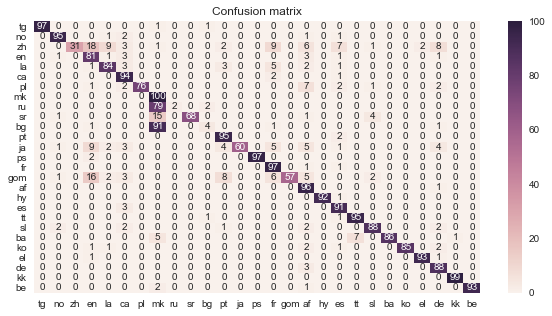

In [153]:
print_result(wiki_texts, predict_language_bigrams, total_bigrams)

             precision    recall  f1-score   support

         af       0.79      1.00      0.88        49
         ba       1.00      0.86      0.92        50
         be       1.00      0.94      0.97        49
         bg       1.00      0.09      0.16        47
         ca       0.71      1.00      0.83        49
         de       0.86      1.00      0.92        48
         el       1.00      1.00      1.00        48
         en       0.60      0.93      0.73        43
         es       0.87      0.98      0.92        46
         fr       0.72      1.00      0.84        46
        gom       1.00      0.48      0.65        50
         hy       1.00      1.00      1.00        48
         ja       1.00      0.48      0.65        48
         kk       1.00      0.98      0.99        50
         ko       1.00      0.91      0.95        46
         la       0.85      0.78      0.81        50
         mk       0.32      1.00      0.49        50
         no       0.94      0.96      0.95   

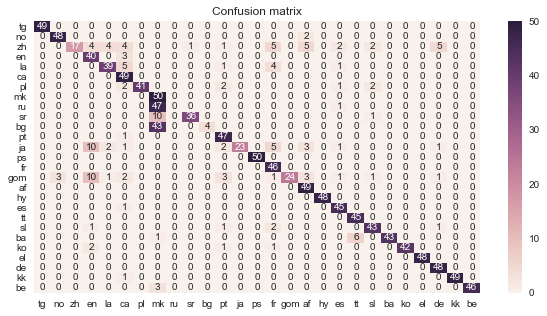

In [154]:
print_result(TEST, predict_language_bigrams, total_bigrams)

# Выводы

## Сравнение методов

Отбор 500 самых частотных значений по всем методам

precision

recall

f1-score   

** словоформы **

Train
0.91      0.86      0.87 


Test
0.90      0.85      0.85

** триграммы **

Train
0.92      0.90      0.89

Test
0.91      0.89      0.88


** биграммы **

Train
0.88      0.83      0.81 


Test
0.86      0.82      0.80

Лучше работает метод триграмм, так как они более тонко, чем биграммы оценивают текст. Биграммы хуже словоформ.

## Проблемные места

             precision    recall  f1-score   support

         af       0.79      1.00      0.88        97
         bg       0.70      0.99      0.82        98
         ca       0.96      0.54      0.69        97
         de       0.00      0.00      0.00         0
         el       0.00      0.00      0.00         0
         en       0.60      1.00      0.75        91
         es       0.50      1.00      0.67        94
         fr       0.90      0.79      0.84        99
        gom       1.00      0.63      0.77       100
         ja       0.99      0.72      0.83        94
         la       1.00      0.59      0.74        99
         no       0.00      0.00      0.00         0
         pl       0.00      0.00      0.00         0
         pt       0.96      0.76      0.85        97
         ru       1.00      0.49      0.66        83
         tg       0.00      0.00      0.00         0
         zh       0.98      0.65      0.78        97

avg / total       0.87      0.76      0.78  

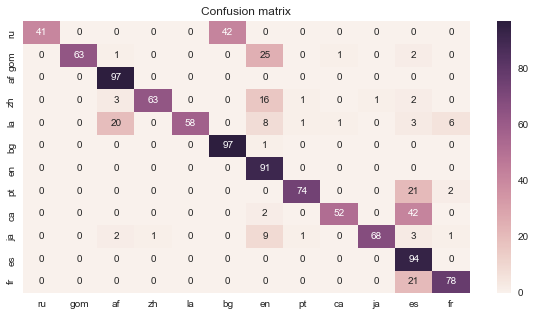

In [182]:
hard = ['zh','la','ca','ru','pt','fr','gom','bg','af','es','ja', 'en']
hard = {lang: wiki_texts[lang]for lang in hard}
print_result(hard, predict_language_word, total_freqs)

             precision    recall  f1-score   support

         af       0.00      0.00      0.00         0
         bg       0.88      0.83      0.85        98
         ca       0.00      0.00      0.00         0
         de       0.81      1.00      0.90        91
         el       0.00      0.00      0.00         0
         en       0.00      0.00      0.00         0
         es       0.84      0.99      0.91        94
         fr       0.92      0.99      0.95        99
        gom       1.00      0.54      0.70       100
         ja       0.86      0.73      0.79        94
         la       0.00      0.00      0.00         0
         mk       0.00      0.00      0.00         0
         no       0.00      0.00      0.00         0
         pt       0.98      0.88      0.92        97
         ru       1.00      0.65      0.79        83
         sl       0.00      0.00      0.00         0
         zh       0.96      0.23      0.37        97

avg / total       0.92      0.76      0.80  

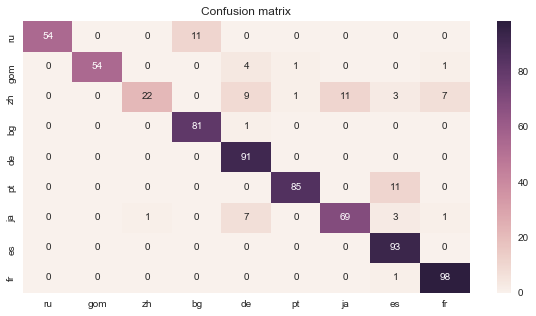

In [183]:
hard = ['zh','ru','bg','ja','gom','pt','fr',
        'es','de']
hard = {lang: wiki_texts[lang]for lang in hard}
print_result(hard, predict_language_ngrams, total_ngrams)

In [161]:
for word in sorted(total_bigrams['zh'], key=lambda w: total_bigrams['zh'][w], reverse=True)[:10]:
    print('{}\t{}'.format(total_bigrams['zh'][word], word))

0.0035428056573656433	天津
0.002591754217162307	現今
0.002552822286861586	年現
0.0020133369669801614	re
0.0020077752626514868	年月
0.0015072218730707838	海軍
0.0014182346038119921	月日
0.0013793026735112708	睡眠
0.0013514941518678984	in
0.001345932447539224	今 


In [160]:
for word in sorted(total_freqs['zh'], key=lambda w: total_freqs['zh'][w], reverse=True)[:10]:
    print('{}\t{}'.format(total_freqs['zh'][word], word))

0.01340282948622487	of
0.010672623479771656	the
0.010424422933730455	and
0.008687019111442046	
0.007446016381236039	外部連結
0.005956813104988831	参考文献
0.005460412012906428	x
0.0052122114668652275	in
0.004467609828741623	參考資料
0.004219409282700422	外部链接


In [202]:
for word in sorted(total_freqs['en'], key=lambda w: total_freqs['en'][w], reverse=True)[:10]:
    print('{}\t{}'.format(total_freqs['en'][word], word))

0.06049577303338587	the
0.03372976071070354	of
0.02885800257916607	in
0.028284854563691075	and
0.02238143000429861	a
0.021435735778764866	to
0.012007450924201175	is
0.009886803266943689	was
0.00934231265224244	as
0.009256340449921192	on


Это может быть проблемой выборки или особенностью текстов в целом, но, например, в китайских текстах много англиских вставок, что приводит к неожиданной ошибке определения языка. Как уже было сказано выше, в иероглифических языках довольно сложно работать в рамках триграмм в силу разнообразия, поэтому ОЧЕНЬ частотные вставки из английского (с артиклями и подобными) сильно смещает результат.

### Решение

In [206]:
NGRAMS = collections.defaultdict(lambda: collections.defaultdict(lambda: 0))

for lang in wiki_texts.keys():
    summ = sum(total_ngrams[lang].values())
    for word in total_ngrams[lang]:
        NGRAMS[lang][word] = total_ngrams[lang][word]/summ

In [208]:
for word in sorted(NGRAMS['zh'], key=lambda w: NGRAMS['zh'][w], reverse=True)[:10]:
    print('{}\t{}'.format(NGRAMS['zh'][word], word))

0.033688073394495505	年現今
0.017614678899082612	現今 
0.014752293577981688	年月日
0.014678899082568846	rem
0.01181651376146792	em睡
0.01181651376146792	m睡眠
0.011376146788990855	伐利亚
0.011302752293578012	總統 
0.011229357798165166	巴伐利
0.011009174311926634	現今總


In [209]:
for word in sorted(NGRAMS['en'], key=lambda w: NGRAMS['en'][w], reverse=True)[:10]:
    print('{}\t{}'.format(NGRAMS['en'][word], word))

0.02266834409855932	 th
0.020228908083892022	the
0.019193298455023832	he 
0.01166019730281224	ed 
0.011598827843323754	 in
0.010409794565734348	 an
0.010087604903419799	and
0.010010893079059193	nd 
0.009512266220715248	in 
0.009458567943662823	 of


             precision    recall  f1-score   support

         af       0.94      1.00      0.97        49
         ba       1.00      1.00      1.00        50
         be       1.00      1.00      1.00        49
         bg       0.90      1.00      0.95        47
         ca       0.96      0.94      0.95        49
         de       0.86      1.00      0.92        48
         el       0.96      1.00      0.98        48
         en       0.56      1.00      0.72        43
         es       0.82      1.00      0.90        46
         fr       0.92      1.00      0.96        46
        gom       1.00      0.56      0.72        50
         hy       1.00      1.00      1.00        48
         ja       1.00      0.77      0.87        48
         kk       1.00      1.00      1.00        50
         ko       1.00      0.93      0.97        46
         la       0.92      0.94      0.93        50
         mk       0.98      1.00      0.99        50
         no       0.98      1.00      0.99   

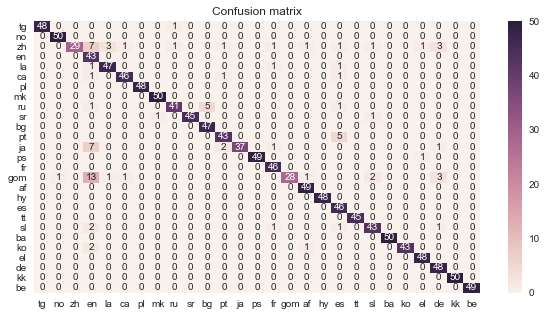

In [238]:
print_result(TEST, predict_language_ngrams, NGRAMS)

Это заметно улучшает результат. Можно считать это лучшим решением. Это простейшая нормализация, можно подумать над более оптимальной (например, с учетом квадр. отклонения)

# Функция с вероятностью

In [229]:
def predict_proba(text, NGRAMS):
    text_words = make_ngrams(text)
    variants = {}
    
    for lang in NGRAMS.keys():
        summ = 0
        for word in text_words:
            if word in NGRAMS[lang]:
                summ += NGRAMS[lang][word]
        variants[lang] = summ
    summ = sum(variants.values())
    
    for lang in NGRAMS.keys():
        variants[lang] = variants[lang]/summ
        
    return [(lang, variants[lang]) for lang in sorted(variants, key=variants.get, reverse=True)]
#     return lang2sim

In [243]:
predict_proba(wiki_texts['zh'][5], NGRAMS)

[('zh', 0.21041140263917066),
 ('en', 0.14400866047599212),
 ('fr', 0.06875295561174423),
 ('la', 0.06665244097242079),
 ('ca', 0.05720827240258246),
 ('de', 0.055624753355813794),
 ('es', 0.055046019142953796),
 ('no', 0.05197743907449311),
 ('af', 0.051253207543763286),
 ('ja', 0.04950851697105822),
 ('pt', 0.04768010684127092),
 ('sl', 0.04595225689970815),
 ('gom', 0.03197305593421519),
 ('pl', 0.028279575919770004),
 ('ko', 0.014383334938388075),
 ('hy', 0.007207095373102321),
 ('tg', 0.005459112646000862),
 ('el', 0.005318756016885596),
 ('ps', 0.002457849426703132),
 ('bg', 0.0005310142825152016),
 ('mk', 0.0003141735314479749),
 ('ru', 0.0),
 ('be', 0.0),
 ('kk', 0.0),
 ('ba', 0.0),
 ('sr', 0.0),
 ('tt', 0.0)]

А греческий очень хорошо определяется

In [244]:
predict_proba(wiki_texts['el'][0], NGRAMS) [:3]

[('el', 0.9632181721144949),
 ('no', 0.005292215521104215),
 ('de', 0.005274712325737782)]

Видно и сходство романских языков:

In [245]:
predict_proba(wiki_texts['es'][8], NGRAMS)[:4]

[('es', 0.17942920773204832),
 ('ca', 0.14550838598121021),
 ('pt', 0.13607180251885673),
 ('fr', 0.1135026134131171)]